<a href="https://colab.research.google.com/github/chacha715/ESAA/blob/main/%EB%B3%91%EC%9B%90_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import pandas as pd
import numpy as np

In [141]:
#train = pd.read_csv('/content/drive/MyDrive/ESAA/YB 1조/9565_hospital_data/train.csv')
#test = pd.read_csv('/content/drive/MyDrive/ESAA/YB 1조/9565_hospital_data/test.csv')

train = pd.read_csv('/content/drive/MyDrive/ESAA/YB 1조/train 지역변수 추가.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA/YB 1조/test 지역변수 추가.csv')



```
# EDA 전처리
```



In [142]:
#train.drop(['inst_id','sgg'],axis=1,inplace=True)

train.dropna(subset=['instkind'],axis=0,inplace=True)
test.dropna(subset=['instkind'],axis=0,inplace=True)

In [143]:
#train.dropna(subset=['instkind'],axis=0,inplace=True)

train['ownerChange'].mode()[0]
train.loc[train['ownerChange'].isna(),'ownerChange'] = train['ownerChange'].mode()[0]
train['ownerChange'].isna().sum()

test['ownerChange'].mode()[0]
test.loc[test['ownerChange'].isna(),'ownerChange'] = test['ownerChange'].mode()[0]
test['ownerChange'].isna().sum()

0

In [144]:
train.dropna(subset=['salescost1'],axis=0,inplace=True)
test.dropna(subset=['salescost1'],axis=0,inplace=True)

In [145]:
train.groupby('instkind')['bedCount'].mean()
train['bedCount'] = train['bedCount'].fillna(train.groupby('instkind')['bedCount'].transform('mean')) 
train['bedCount'].isnull().sum()

test.groupby('instkind')['bedCount'].mean()
test['bedCount'] = test['bedCount'].fillna(test.groupby('instkind')['bedCount'].transform('mean')) 
test['bedCount'].isnull().sum()

1

In [146]:
for i in range(0,len(train["OC"])):
  if train.iloc[i,0] == "open":
    train.iloc[i, 0]=1
  else:
    train.iloc[i, 0]=0 

In [147]:
round(train['ownerChange'].value_counts(normalize=True),3)
train['ownerChange'] = train['ownerChange'].fillna(pd.Series(np.random.choice(['same','change'], p=[0.85,0.15],size = 300))) 

In [148]:
train['OC'] = train['OC'].map({'close': 0, 'open': 1})
#train['OC'].fillna(0, inplace=True)

In [ ]:
train['OC'].describe

In [ ]:
train['OC'].isna().sum()

In [150]:
a = train
a['OC'].fillna(0, inplace=True)

In [151]:
train = a

In [ ]:
train.tail()



```
# 파생변수 생성
```



In [21]:
#매출액순이익율=당기순이익/자기자본*100

train['매출액순이익율'] = train.profit1/train.revenue1*100

In [154]:
#배당성향=배당금/당기순이익
#배당금=당기순이익-이익잉여금

train['배당성향'] = (train.profit1-train.surplus1)/train.profit1

In [23]:
#이자보상비율=영업이익/이자비용*100
#영업손익은 매출액 등의 영업수익으로부터 매출원가ㆍ판매비와관리비 등의 영업비용을 차감한 개념 (영업 외 이익과 비용도 차감)

train['이자보상비율'] = (train.revenue1-train.salescost1-train.sga1-train.noi1-train.noe1)/train.interest1*100

In [155]:
##은서

#재고자산회전율=매출원가/평균재고자산
#train['재고자산회전율']=train.salescost1/((train.inventoryAsset1+train.inventoryAsset2)/2)

#자기자본비율=자기자본/총자본*100
train['자기자본비율']=train.netAsset1/(train.debt1+train.netAsset1)*100

In [156]:
##현서

#유동비율 = 유동자산/유동부채 *100
#train['유동비율']=(train['liquidAsset1']/train['liquidLiabilities1'])*100
#당좌비율 = (유동자산-재고자산)/유동부채 *100
#train['당좌비율']=(train['quickAsset1']/train['liquidLiabilities1'])*100
#부채비율 = 부채/자본 *100
train['부채비율']=(train['debt1']/(train['debt1']+train['netAsset1']))*100

In [26]:
##재령

train['매출액증가율']=(train['revenue1']/train['revenue2'])*100-100
train['총자산증가율']=(train['netAsset1']+train['debt1'])/(train['netAsset2']+train['debt2'])*100 -100
train['ROE']=(train['profit1']/train['netAsset1'])*100

In [157]:
##미수

train.loc[train.bedCount>300,'hospital_size']=1
train.loc[train.bedCount<=300,'hospital_size']=0

In [ ]:
train.describe()

In [158]:
train['OC'].count()

292

In [159]:
train['OC'].describe

<bound method NDFrame.describe of 0      1.0
2      1.0
3      1.0
4      1.0
5      1.0
      ... 
296    1.0
297    0.0
298    0.0
299    0.0
300    1.0
Name: OC, Length: 292, dtype: float64>



```
# XGBoost 모델
```



In [174]:
import xgboost as xgb
from xgboost import XGBClassifier

In [161]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [162]:
X_features = train.drop(columns = ['OC', 'sido', 'instkind', 'ownerChange']) #int형 아닌 열 삭제. sido랑 instkind는 파생변수로 적용, ownerChange는 지울까,,
y_label = train['OC']

X_train,X_test,y_train,y_test = train_test_split(X_features,y_label, test_size = 0.2, random_state = 156, stratify = y_label)
print(X_train.shape,X_test.shape)

(233, 59) (59, 59)


In [163]:
print(y_train.value_counts()/y_train.shape[0]*100)
print(y_test.value_counts()/y_test.shape[0]*100)

1.0    95.27897
0.0     4.72103
Name: OC, dtype: float64
1.0    94.915254
0.0     5.084746
Name: OC, dtype: float64


In [ ]:
#X_train.info()
#y_train.info()
y_train.head()

In [165]:
dtrain = xgb.DMatrix(data=X_train,label = y_train)
dtest = xgb.DMatrix(data=X_test,label = y_test)

In [166]:
params = {
    'max_depth' :3,
    'eta' : 0.1,
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds = 400

In [ ]:
wlist=[(dtrain,'train'),(dtest,'eval')]
#하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_rounds, early_stopping_rounds=100,evals=wlist)

In [168]:
pred_probs=xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 활률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:',preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨
[0.999 0.998 0.997 0.998 0.997 0.999 0.994 0.987 0.997 0.998]
예측값 10개만 표시: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.metrics import f1_score,confusion_matrix,precision_recall_curve,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [170]:
def get_clf_eval(y_test, pred=None, pred_proba=None): #평가 한번에 호출하는 함수
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)

  print('오차행렬')
  print(confusion)
  print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율:{2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [171]:
get_clf_eval(y_test,preds,pred_probs)

오차행렬
[[ 0  3]
 [ 2 54]]
정확도 : 0.9153, 정밀도 : 0.9474, 재현율:0.9643, F1 : 0.9558, AUC : 0.8095


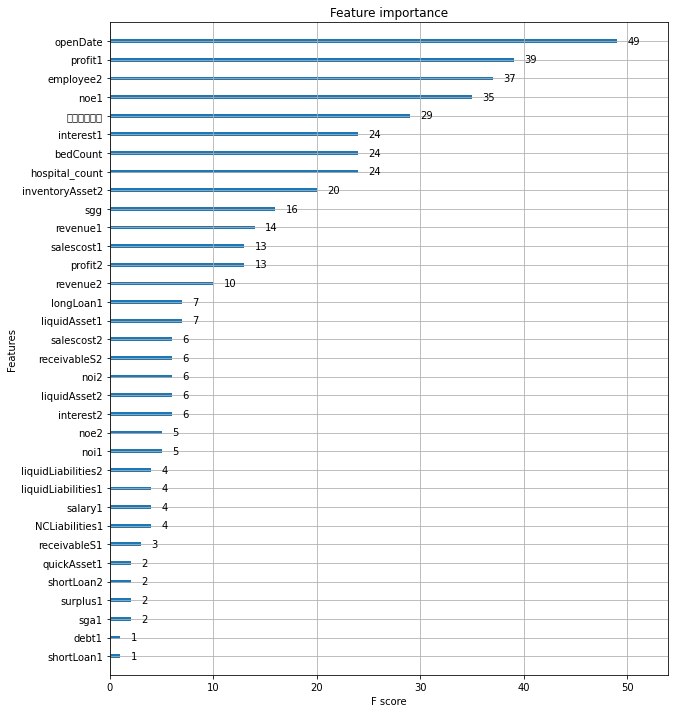

In [172]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

In [176]:
xgb.cv(params,dtrain,num_boost_round=10,nfold=3,stratified=False,metrics=(),obj=None,feval=None,maximize=False,early_stopping_rounds=None,fpreproc=None,as_pandas=True,verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.613357,0.001069,0.618499,0.000779
1,0.548317,0.002165,0.556972,0.001482
2,0.493234,0.003646,0.507176,0.003371
3,0.446821,0.004530,0.463530,0.003898
4,0.406985,0.005205,0.426844,0.006757
5,0.371851,0.005623,0.394614,0.007845
6,0.340191,0.005925,0.367998,0.009078
7,0.312730,0.005694,0.344538,0.009933
8,0.287562,0.006247,0.324211,0.010887
9,0.265093,0.006646,0.306768,0.013462
